<a href="https://colab.research.google.com/github/olaf-ys/Big-Query-GCP/blob/main/BA820_group.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [1]:
import pandas as pd
import datetime
import numpy as np

# NLP
import re
import spacy

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
from gensim import corpora, models

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# sklean
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
# Clear all files in the current working directory for each run
!rm -rf /content/*

# Download the data directly from UCI repository
!wget https://archive.ics.uci.edu/static/public/911/recipe+reviews+and+user+feedback+dataset.zip

# Unzip the download file
!unzip /content/recipe+reviews+and+user+feedback+dataset.zip

--2024-02-17 03:05:15--  https://archive.ics.uci.edu/static/public/911/recipe+reviews+and+user+feedback+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘recipe+reviews+and+user+feedback+dataset.zip’

recipe+reviews+and+     [ <=>                ]   2.02M  10.6MB/s    in 0.2s    

2024-02-17 03:05:15 (10.6 MB/s) - ‘recipe+reviews+and+user+feedback+dataset.zip’ saved [2114088]

Archive:  /content/recipe+reviews+and+user+feedback+dataset.zip
  inflating: Recipe Reviews and User Feedback Dataset.csv  


In [3]:
# Show all columns & rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load the dataset
data = pd.read_csv('/content/Recipe Reviews and User Feedback Dataset.csv')
data.head()

,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,5,710,I have a very complicated white chicken chili ...
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...


# **EDA**

## Check Missing Values

Before we work on the dataset, we want to make sure that there is no null value. To check, we look at the dataset information.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18182 entries, 0 to 18181
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       18182 non-null  int64 
 1   recipe_number    18182 non-null  int64 
 2   recipe_code      18182 non-null  int64 
 3   recipe_name      18182 non-null  object
 4   comment_id       18182 non-null  object
 5   user_id          18182 non-null  object
 6   user_name        18182 non-null  object
 7   user_reputation  18182 non-null  int64 
 8   created_at       18182 non-null  int64 
 9   reply_count      18182 non-null  int64 
 10  thumbs_up        18182 non-null  int64 
 11  thumbs_down      18182 non-null  int64 
 12  stars            18182 non-null  int64 
 13  best_score       18182 non-null  int64 
 14  text             18180 non-null  object
dtypes: int64(10), object(5)
memory usage: 2.1+ MB


In [5]:
# drop null values
data = data.dropna()

There are 2 missing values in the text column, so we simply drop the two rows

## Check Duplicates

In [6]:
# drop duplicates if any
data.drop_duplicates(inplace=True)

In [7]:
data.to_csv('cleaned_data.csv', index = False)

## Identify categorical & numeric features

To train the model which predicts buyers' decisions, we may need to identify categorical and numeric variables first.

To have an overview of all of the features, we count the unique values and look at the data type of each of them.

In [8]:
# Calculate the number of unique values and data types for each feature
unique_count = data.nunique()
data_types = data.dtypes

# Create a new DataFrame containing feature names, unique value counts, and data types
unique_count_df = pd.DataFrame({'Feature': unique_count.index, 'Unique Count': unique_count.values, 'Data Type': data_types}).reset_index(drop=True)

unique_count_df

,Feature,Unique Count,Data Type
0,Unnamed: 0,725,int64
1,recipe_number,100,int64
2,recipe_code,100,int64
3,recipe_name,100,object
4,comment_id,18180,object
5,user_id,13812,object
6,user_name,13586,object
7,user_reputation,22,int64
8,created_at,2695,int64
9,reply_count,4,int64


# Preprocess the text column

## Remove HTML entities and special characters

In [9]:
# Set pandas to display the full content of text columns
pd.set_option('display.max_colwidth', None)

# Define a function to clean the text
def clean_text(text):
    # Remove HTML entities and other special characters
    text = re.sub(r'(&#34;|&#[0-9]+;)', '', text)  # Remove HTML entities
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

# Apply the cleaning function to the 'text' column
data['cleaned_text'] = data['text'].apply(clean_text)

# Show the first few rows of the cleaned text
data[['text', 'cleaned_text']].head()

,text,cleaned_text
0,"I tweaked it a little, removed onions because of onion haters in my house, used Italian seasoning instead of just oregano, and use a paprika/ cayenne mix and a little more than the recipe called for.. we like everything a bit more hot. The chili was amazing! It was easy to make and everyone absolutely loved it. It will now be a staple meal in our house.",i tweaked it a little removed onions because of onion haters in my house used italian seasoning instead of just oregano and use a paprika cayenne mix and a little more than the recipe called for we like everything a bit more hot the chili was amazing it was easy to make and everyone absolutely loved it it will now be a staple meal in our house
1,"Bush used to have a white chili bean and it made this recipe super simple. I’ve written to them and asked them to please!, bring them back",bush used to have a white chili bean and it made this recipe super simple ive written to them and asked them to please bring them back
2,"I have a very complicated white chicken chili recipe that I have made for years. Everyone raves over it. I saw this recipe and thought I’d try it as an easy alternative for weeknights. My husband likes this recipe better! Super easy and delicious! I did cut back slightly on the crushed oregano and cayenne pepper, otherwise I made it exactly as written.",i have a very complicated white chicken chili recipe that i have made for years everyone raves over it i saw this recipe and thought id try it as an easy alternative for weeknights my husband likes this recipe better super easy and delicious i did cut back slightly on the crushed oregano and cayenne pepper otherwise i made it exactly as written
3,"In your introduction, you mentioned cream cheese but there is none listed in the ingredients!",in your introduction you mentioned cream cheese but there is none listed in the ingredients
4,Wonderful! I made this for a &#34;Chili/Stew&#34; night dinner at our church and everyone wanted the recipe. We make it quite often at home and it&#39;s always a hit. I also use a freshly made rotisserie chicken which adds to the flavor.,wonderful i made this for a chilistew night dinner at our church and everyone wanted the recipe we make it quite often at home and its always a hit i also use a freshly made rotisserie chicken which adds to the flavor


## Tokenize

In [10]:
data['tokens'] = data['cleaned_text'].apply(lambda x: x.split())
data[['cleaned_text', 'tokens']].head()

,cleaned_text,tokens
0,i tweaked it a little removed onions because of onion haters in my house used italian seasoning instead of just oregano and use a paprika cayenne mix and a little more than the recipe called for we like everything a bit more hot the chili was amazing it was easy to make and everyone absolutely loved it it will now be a staple meal in our house,"[i, tweaked, it, a, little, removed, onions, because, of, onion, haters, in, my, house, used, italian, seasoning, instead, of, just, oregano, and, use, a, paprika, cayenne, mix, and, a, little, more, than, the, recipe, called, for, we, like, everything, a, bit, more, hot, the, chili, was, amazing, it, was, easy, to, make, and, everyone, absolutely, loved, it, it, will, now, be, a, staple, meal, in, our, house]"
1,bush used to have a white chili bean and it made this recipe super simple ive written to them and asked them to please bring them back,"[bush, used, to, have, a, white, chili, bean, and, it, made, this, recipe, super, simple, ive, written, to, them, and, asked, them, to, please, bring, them, back]"
2,i have a very complicated white chicken chili recipe that i have made for years everyone raves over it i saw this recipe and thought id try it as an easy alternative for weeknights my husband likes this recipe better super easy and delicious i did cut back slightly on the crushed oregano and cayenne pepper otherwise i made it exactly as written,"[i, have, a, very, complicated, white, chicken, chili, recipe, that, i, have, made, for, years, everyone, raves, over, it, i, saw, this, recipe, and, thought, id, try, it, as, an, easy, alternative, for, weeknights, my, husband, likes, this, recipe, better, super, easy, and, delicious, i, did, cut, back, slightly, on, the, crushed, oregano, and, cayenne, pepper, otherwise, i, made, it, exactly, as, written]"
3,in your introduction you mentioned cream cheese but there is none listed in the ingredients,"[in, your, introduction, you, mentioned, cream, cheese, but, there, is, none, listed, in, the, ingredients]"
4,wonderful i made this for a chilistew night dinner at our church and everyone wanted the recipe we make it quite often at home and its always a hit i also use a freshly made rotisserie chicken which adds to the flavor,"[wonderful, i, made, this, for, a, chilistew, night, dinner, at, our, church, and, everyone, wanted, the, recipe, we, make, it, quite, often, at, home, and, its, always, a, hit, i, also, use, a, freshly, made, rotisserie, chicken, which, adds, to, the, flavor]"


## Remove stop words

In [11]:
nltk.download('stopwords')

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Apply the function to remove stopwords from tokens
data['tokens_no_stop'] = data['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Show the first few rows to verify the removal of stopwords
data[['tokens', 'tokens_no_stop']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tokens,tokens_no_stop
0,"[i, tweaked, it, a, little, removed, onions, because, of, onion, haters, in, my, house, used, italian, seasoning, instead, of, just, oregano, and, use, a, paprika, cayenne, mix, and, a, little, more, than, the, recipe, called, for, we, like, everything, a, bit, more, hot, the, chili, was, amazing, it, was, easy, to, make, and, everyone, absolutely, loved, it, it, will, now, be, a, staple, meal, in, our, house]","[tweaked, little, removed, onions, onion, haters, house, used, italian, seasoning, instead, oregano, use, paprika, cayenne, mix, little, recipe, called, like, everything, bit, hot, chili, amazing, easy, make, everyone, absolutely, loved, staple, meal, house]"
1,"[bush, used, to, have, a, white, chili, bean, and, it, made, this, recipe, super, simple, ive, written, to, them, and, asked, them, to, please, bring, them, back]","[bush, used, white, chili, bean, made, recipe, super, simple, ive, written, asked, please, bring, back]"
2,"[i, have, a, very, complicated, white, chicken, chili, recipe, that, i, have, made, for, years, everyone, raves, over, it, i, saw, this, recipe, and, thought, id, try, it, as, an, easy, alternative, for, weeknights, my, husband, likes, this, recipe, better, super, easy, and, delicious, i, did, cut, back, slightly, on, the, crushed, oregano, and, cayenne, pepper, otherwise, i, made, it, exactly, as, written]","[complicated, white, chicken, chili, recipe, made, years, everyone, raves, saw, recipe, thought, id, try, easy, alternative, weeknights, husband, likes, recipe, better, super, easy, delicious, cut, back, slightly, crushed, oregano, cayenne, pepper, otherwise, made, exactly, written]"
3,"[in, your, introduction, you, mentioned, cream, cheese, but, there, is, none, listed, in, the, ingredients]","[introduction, mentioned, cream, cheese, none, listed, ingredients]"
4,"[wonderful, i, made, this, for, a, chilistew, night, dinner, at, our, church, and, everyone, wanted, the, recipe, we, make, it, quite, often, at, home, and, its, always, a, hit, i, also, use, a, freshly, made, rotisserie, chicken, which, adds, to, the, flavor]","[wonderful, made, chilistew, night, dinner, church, everyone, wanted, recipe, make, quite, often, home, always, hit, also, use, freshly, made, rotisserie, chicken, adds, flavor]"


## Lemmatization

In [12]:
import spacy
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(token_list):
    # convert token list to strings
    text = ' '.join(token_list)

    # apply spaCy
    doc = nlp(text)

    # retrive each token's lamm_
    lemmatized_list = [token.lemma_ for token in doc]
    return lemmatized_list

# apply lemmatize_text
data['tokens_lemmatized'] = data['tokens_no_stop'].apply(lemmatize_text)

data[['tokens_no_stop', 'tokens_lemmatized']].head()

,tokens_no_stop,tokens_lemmatized
0,"[tweaked, little, removed, onions, onion, haters, house, used, italian, seasoning, instead, oregano, use, paprika, cayenne, mix, little, recipe, called, like, everything, bit, hot, chili, amazing, easy, make, everyone, absolutely, loved, staple, meal, house]","[tweak, little, remove, onion, onion, hater, house, use, italian, seasoning, instead, oregano, use, paprika, cayenne, mix, little, recipe, call, like, everything, bite, hot, chili, amazing, easy, make, everyone, absolutely, love, staple, meal, house]"
1,"[bush, used, white, chili, bean, made, recipe, super, simple, ive, written, asked, please, bring, back]","[bush, use, white, chili, bean, make, recipe, super, simple, I, ve, write, ask, please, bring, back]"
2,"[complicated, white, chicken, chili, recipe, made, years, everyone, raves, saw, recipe, thought, id, try, easy, alternative, weeknights, husband, likes, recipe, better, super, easy, delicious, cut, back, slightly, crushed, oregano, cayenne, pepper, otherwise, made, exactly, written]","[complicate, white, chicken, chili, recipe, make, year, everyone, rave, see, recipe, think, I, d, try, easy, alternative, weeknight, husband, like, recipe, well, super, easy, delicious, cut, back, slightly, crush, oregano, cayenne, pepper, otherwise, make, exactly, write]"
3,"[introduction, mentioned, cream, cheese, none, listed, ingredients]","[introduction, mention, cream, cheese, none, list, ingredient]"
4,"[wonderful, made, chilistew, night, dinner, church, everyone, wanted, recipe, make, quite, often, home, always, hit, also, use, freshly, made, rotisserie, chicken, adds, flavor]","[wonderful, make, chilistew, night, dinner, church, everyone, want, recipe, make, quite, often, home, always, hit, also, use, freshly, make, rotisserie, chicken, add, flavor]"


In [13]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np

# Assuming 'data['tokens_lemmatized']' is your pre-processed list of tokenized documents
sentences = data['tokens_lemmatized'].tolist()

# Create a list of documents where each document is represented by a TaggedDocument object
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(sentences)]

# Initialize the Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=100, # 'vector_size' is the dimensionality of the document vectors
                        window=5, # 'window' is the size of the context window
                        min_count=1 # 'min_count' is the minimum frequency count of words
                        )

# Build the vocabulary
doc2vec_model.build_vocab(documents)

# Train the Doc2Vec model
doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=10)

# Save the model for later use
doc2vec_model.save("doc2vec.model")

# Extract document vectors from the model
doc_vectors = np.zeros((len(documents), 100))

# Iterate over the documents to get the vectors
for i in range(len(documents)):
    doc_vectors[i] = doc2vec_model.dv[i]

# Output the matrix of document vectors
doc_vectors

array([[-0.02335443, -0.02635933,  0.01940405, ...,  0.02371261,
        -0.00628297,  0.03462127],
       [-0.06605945,  0.03885237,  0.02650128, ..., -0.03943668,
        -0.03789945,  0.00103791],
       [-0.09866158, -0.00041484,  0.07520434, ...,  0.00099049,
        -0.08671283, -0.02704949],
       ...,
       [ 0.01280467,  0.03385708, -0.07850514, ..., -0.01064677,
         0.008718  , -0.01472212],
       [-0.02792418, -0.00442825, -0.03320972, ..., -0.02787886,
         0.016178  ,  0.02655123],
       [ 0.06030477,  0.08168077,  0.00132859, ..., -0.00931781,
         0.01438053, -0.01650939]])

# Proprocess Other Columns

In [14]:
# reset df view options
pd.reset_option('all')


data['created_at'] = pd.to_datetime(data['created_at'], unit='s')
data['time'] = pd.to_datetime(data['created_at'], unit='s')
data['created_at']=data['created_at'].dt.strftime('%Y-%m-%d %H:%M:%S')
data.head()

,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text,cleaned_text,tokens,tokens_no_stop,tokens_lemmatized,time
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,2022-10-13 00:11:29,0,0,0,5,527,"I tweaked it a little, removed onions because ...",i tweaked it a little removed onions because o...,"[i, tweaked, it, a, little, removed, onions, b...","[tweaked, little, removed, onions, onion, hate...","[tweak, little, remove, onion, onion, hater, h...",2022-10-13 00:11:29
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,2022-10-09 01:08:07,0,7,0,5,724,Bush used to have a white chili bean and it ma...,bush used to have a white chili bean and it ma...,"[bush, used, to, have, a, white, chili, bean, ...","[bush, used, white, chili, bean, made, recipe,...","[bush, use, white, chili, bean, make, recipe, ...",2022-10-09 01:08:07
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,2022-09-28 22:35:57,0,3,0,5,710,I have a very complicated white chicken chili ...,i have a very complicated white chicken chili ...,"[i, have, a, very, complicated, white, chicken...","[complicated, white, chicken, chili, recipe, m...","[complicate, white, chicken, chili, recipe, ma...",2022-09-28 22:35:57
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,2022-08-29 15:43:28,2,2,0,0,581,"In your introduction, you mentioned cream chee...",in your introduction you mentioned cream chees...,"[in, your, introduction, you, mentioned, cream...","[introduction, mentioned, cream, cheese, none,...","[introduction, mention, cream, cheese, none, l...",2022-08-29 15:43:28
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,2022-10-04 20:03:43,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...,wonderful i made this for a chilistew night di...,"[wonderful, i, made, this, for, a, chilistew, ...","[wonderful, made, chilistew, night, dinner, ch...","[wonderful, make, chilistew, night, dinner, ch...",2022-10-04 20:03:43


* We seperate daily time to 4 period: morning for 6-12, afternoon for 12-18, evening for 18-0, night for 0-6.

In [15]:
data.loc[(data['time'].dt.hour >= 0) & (data['time'].dt.hour < 6), 'day_period'] = 'night'
data.loc[(data['time'].dt.hour >= 6) & (data['time'].dt.hour < 12), 'day_period'] = 'morning'
data.loc[(data['time'].dt.hour >= 12) & (data['time'].dt.hour < 18), 'day_period'] = 'afternoon'
data.loc[(data['time'].dt.hour >= 18) & (data['time'].dt.hour < 24), 'day_period'] = 'evening'

In [16]:
data['hour_of_day'] = pd.to_datetime(data['time']).dt.hour

In [17]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

data['season'] = data['time'].dt.month.apply(lambda x: get_season(x))

In [18]:
days = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

data['weekday'] = data['time'].dt.dayofweek.map(lambda x: days[x])
data.head()

,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,...,text,cleaned_text,tokens,tokens_no_stop,tokens_lemmatized,time,day_period,hour_of_day,season,weekday
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,2022-10-13 00:11:29,0,...,"I tweaked it a little, removed onions because ...",i tweaked it a little removed onions because o...,"[i, tweaked, it, a, little, removed, onions, b...","[tweaked, little, removed, onions, onion, hate...","[tweak, little, remove, onion, onion, hater, h...",2022-10-13 00:11:29,night,0,Autumn,Thursday
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,2022-10-09 01:08:07,0,...,Bush used to have a white chili bean and it ma...,bush used to have a white chili bean and it ma...,"[bush, used, to, have, a, white, chili, bean, ...","[bush, used, white, chili, bean, made, recipe,...","[bush, use, white, chili, bean, make, recipe, ...",2022-10-09 01:08:07,night,1,Autumn,Sunday
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,2022-09-28 22:35:57,0,...,I have a very complicated white chicken chili ...,i have a very complicated white chicken chili ...,"[i, have, a, very, complicated, white, chicken...","[complicated, white, chicken, chili, recipe, m...","[complicate, white, chicken, chili, recipe, ma...",2022-09-28 22:35:57,evening,22,Autumn,Wednesday
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,2022-08-29 15:43:28,2,...,"In your introduction, you mentioned cream chee...",in your introduction you mentioned cream chees...,"[in, your, introduction, you, mentioned, cream...","[introduction, mentioned, cream, cheese, none,...","[introduction, mention, cream, cheese, none, l...",2022-08-29 15:43:28,afternoon,15,Summer,Monday
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,2022-10-04 20:03:43,1,...,Wonderful! I made this for a &#34;Chili/Stew&#...,wonderful i made this for a chilistew night di...,"[wonderful, i, made, this, for, a, chilistew, ...","[wonderful, made, chilistew, night, dinner, ch...","[wonderful, make, chilistew, night, dinner, ch...",2022-10-04 20:03:43,evening,20,Autumn,Tuesday


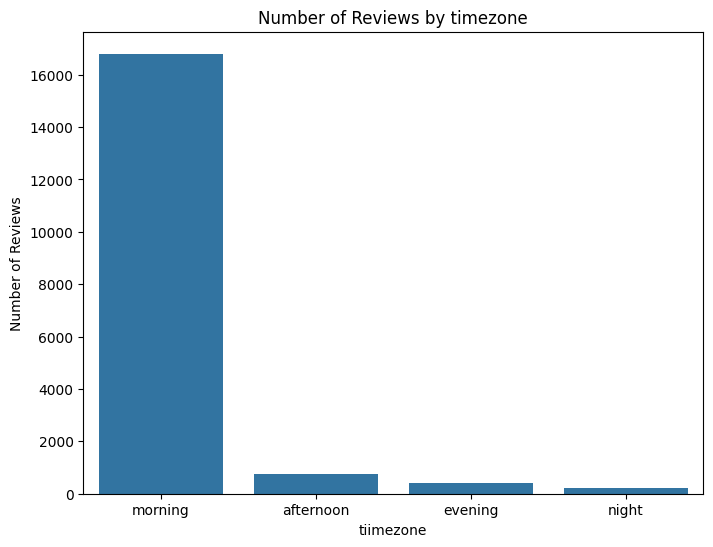

In [19]:
timezone_review_counts = data['day_period'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=timezone_review_counts.index, y=timezone_review_counts.values)

plt.title('Number of Reviews by timezone')
plt.xlabel('tiimezone')
plt.ylabel('Number of Reviews')

plt.show()

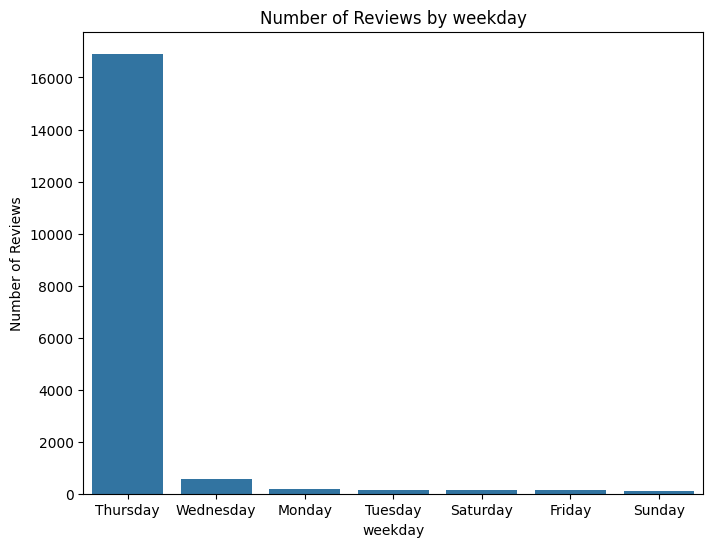

In [20]:
weekday_review_counts = data['weekday'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=weekday_review_counts.index, y=weekday_review_counts.values)

plt.title('Number of Reviews by weekday')
plt.xlabel('weekday')
plt.ylabel('Number of Reviews')

plt.show()

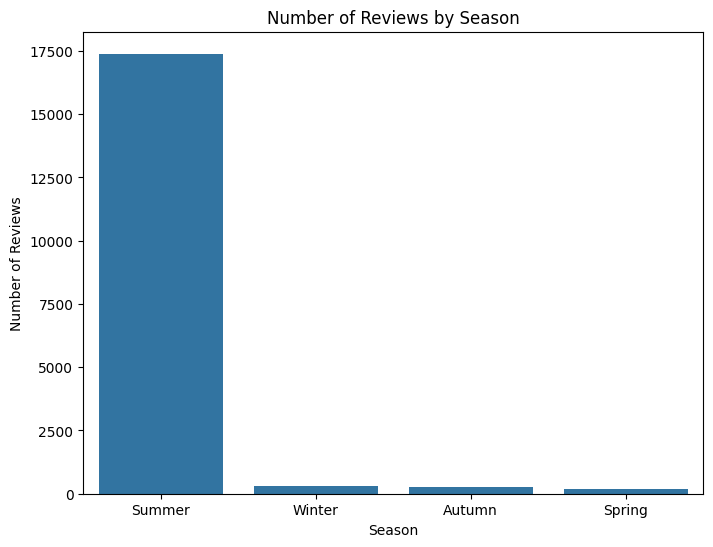

In [21]:
import seaborn as sns

season_review_counts = data['season'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=season_review_counts.index, y=season_review_counts.values)

plt.title('Number of Reviews by Season')
plt.xlabel('Season')
plt.ylabel('Number of Reviews')

plt.show()

From these three plots, we can see that our data has a distince distribution on season/day_period/weekday level. Thus we will process the data to be in this form:
ternary feature is timezone, the possible values are:

*   A ternary feature: 'timezone', the possible values are: 10, 11, and 0
*   Two binary feature:
    'Thursday': the values are 0 and 1
    'Summer' : The values are 0 and 1


In [22]:
data['Thursday'] = (data['weekday'] == 'Thursday').astype(int)
data['Summer'] = (data['season'] == 'Summer').astype(int)
data['Morning'] = (data['day_period'] == 'morning').astype(int)

data.drop(['weekday', 'season','day_period','hour_of_day'], axis=1, inplace=True)

In [23]:
data.head()

,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,...,best_score,text,cleaned_text,tokens,tokens_no_stop,tokens_lemmatized,time,Thursday,Summer,Morning
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,2022-10-13 00:11:29,0,...,527,"I tweaked it a little, removed onions because ...",i tweaked it a little removed onions because o...,"[i, tweaked, it, a, little, removed, onions, b...","[tweaked, little, removed, onions, onion, hate...","[tweak, little, remove, onion, onion, hater, h...",2022-10-13 00:11:29,1,0,0
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,2022-10-09 01:08:07,0,...,724,Bush used to have a white chili bean and it ma...,bush used to have a white chili bean and it ma...,"[bush, used, to, have, a, white, chili, bean, ...","[bush, used, white, chili, bean, made, recipe,...","[bush, use, white, chili, bean, make, recipe, ...",2022-10-09 01:08:07,0,0,0
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,2022-09-28 22:35:57,0,...,710,I have a very complicated white chicken chili ...,i have a very complicated white chicken chili ...,"[i, have, a, very, complicated, white, chicken...","[complicated, white, chicken, chili, recipe, m...","[complicate, white, chicken, chili, recipe, ma...",2022-09-28 22:35:57,0,0,0
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,2022-08-29 15:43:28,2,...,581,"In your introduction, you mentioned cream chee...",in your introduction you mentioned cream chees...,"[in, your, introduction, you, mentioned, cream...","[introduction, mentioned, cream, cheese, none,...","[introduction, mention, cream, cheese, none, l...",2022-08-29 15:43:28,0,1,0
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,2022-10-04 20:03:43,1,...,820,Wonderful! I made this for a &#34;Chili/Stew&#...,wonderful i made this for a chilistew night di...,"[wonderful, i, made, this, for, a, chilistew, ...","[wonderful, made, chilistew, night, dinner, ch...","[wonderful, make, chilistew, night, dinner, ch...",2022-10-04 20:03:43,0,0,0


drop some unuseful columns

In [24]:
df1 = data.drop(['Unnamed: 0','recipe_number','recipe_code','comment_id','user_id','user_name','user_reputation','created_at','recipe_name','time'], axis = 1)

After we check the text content and its best score, we found that the best_score correlate with the emotion of the text. So to align with the study paper of this dataset, we create a column called 'best_score_bin', which has 5 values: 'very negative','negative','neutral','positive','very positive'. This column will be used to check the result of our following sentimental analysis.

In [25]:
bins = [0, 200, 400, 600, 800, 1000]
labels = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
df1['sentiment'] = pd.cut(df1['best_score'], bins=bins, labels=labels, right=False)
df1.drop('best_score', axis = 1, inplace = True)
df1.head()

,reply_count,thumbs_up,thumbs_down,stars,text,cleaned_text,tokens,tokens_no_stop,tokens_lemmatized,Thursday,Summer,Morning,sentiment
0,0,0,0,5,"I tweaked it a little, removed onions because ...",i tweaked it a little removed onions because o...,"[i, tweaked, it, a, little, removed, onions, b...","[tweaked, little, removed, onions, onion, hate...","[tweak, little, remove, onion, onion, hater, h...",1,0,0,neutral
1,0,7,0,5,Bush used to have a white chili bean and it ma...,bush used to have a white chili bean and it ma...,"[bush, used, to, have, a, white, chili, bean, ...","[bush, used, white, chili, bean, made, recipe,...","[bush, use, white, chili, bean, make, recipe, ...",0,0,0,positive
2,0,3,0,5,I have a very complicated white chicken chili ...,i have a very complicated white chicken chili ...,"[i, have, a, very, complicated, white, chicken...","[complicated, white, chicken, chili, recipe, m...","[complicate, white, chicken, chili, recipe, ma...",0,0,0,positive
3,2,2,0,0,"In your introduction, you mentioned cream chee...",in your introduction you mentioned cream chees...,"[in, your, introduction, you, mentioned, cream...","[introduction, mentioned, cream, cheese, none,...","[introduction, mention, cream, cheese, none, l...",0,1,0,neutral
4,1,7,0,0,Wonderful! I made this for a &#34;Chili/Stew&#...,wonderful i made this for a chilistew night di...,"[wonderful, i, made, this, for, a, chilistew, ...","[wonderful, made, chilistew, night, dinner, ch...","[wonderful, make, chilistew, night, dinner, ch...",0,0,0,very_positive


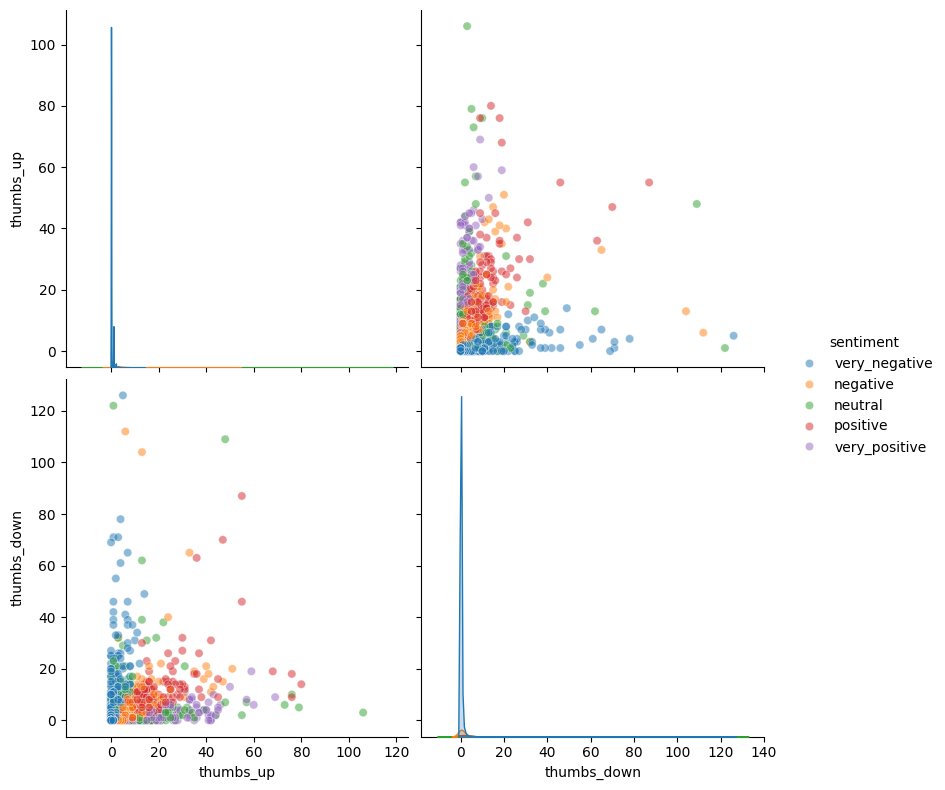

In [26]:
plot_kws = {'alpha': 0.5}
sns.pairplot(df1, vars = ['thumbs_up', 'thumbs_down'], hue = 'sentiment',height=4,plot_kws = plot_kws)
plt.show()

In [27]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18180 entries, 0 to 18181
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   reply_count        18180 non-null  int64   
 1   thumbs_up          18180 non-null  int64   
 2   thumbs_down        18180 non-null  int64   
 3   stars              18180 non-null  int64   
 4   text               18180 non-null  object  
 5   cleaned_text       18180 non-null  object  
 6   tokens             18180 non-null  object  
 7   tokens_no_stop     18180 non-null  object  
 8   tokens_lemmatized  18180 non-null  object  
 9   Thursday           18180 non-null  int64   
 10  Summer             18180 non-null  int64   
 11  Morning            18180 non-null  int64   
 12  sentiment          18180 non-null  category
dtypes: category(1), int64(7), object(5)
memory usage: 1.8+ MB


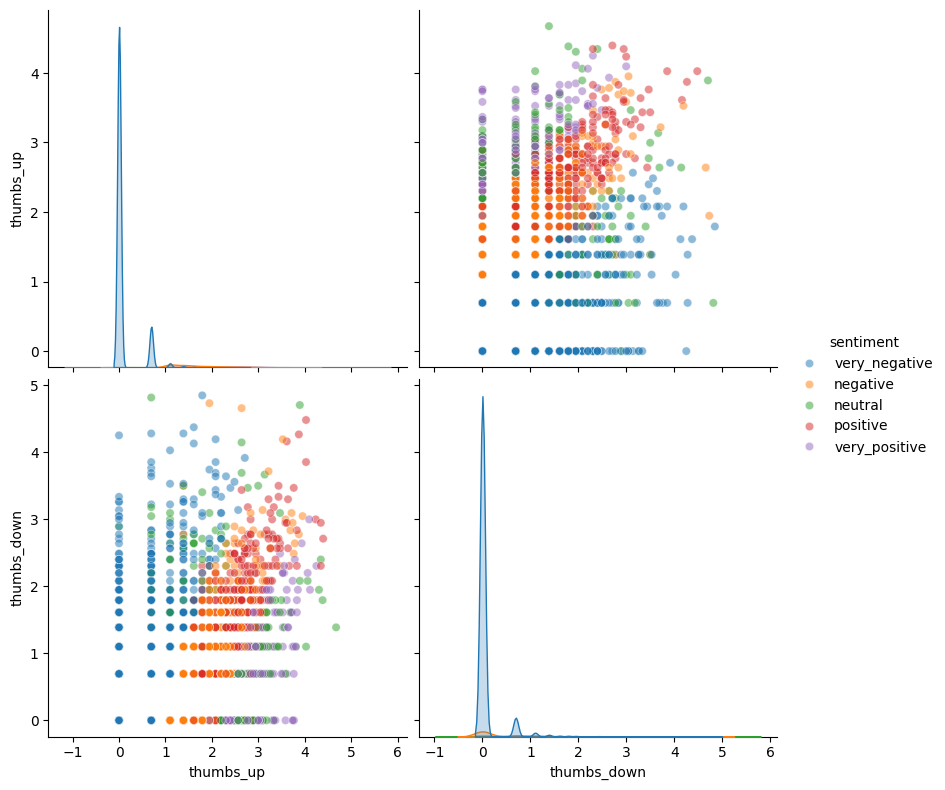

In [28]:
df1['thumbs_up'] = np.log1p(df1['thumbs_up'])
df1['thumbs_down'] = np.log1p(df1['thumbs_down'])

sns.pairplot(df1, vars = ['thumbs_up', 'thumbs_down'], hue = 'sentiment',height=4,plot_kws = plot_kws)
plt.show()

In [32]:
# standardization
scaler = StandardScaler()
X_non_text = df1[['reply_count', 'thumbs_up', 'thumbs_down', 'stars']]
X_non_text = scaler.fit_transform(X_non_text)
X_doc_vectors = scaler.fit_transform(doc_vectors)

In [34]:
X_binary = df1[['Thursday', 'Summer', 'Morning']].values
X = np.hstack((X_non_text, X_binary, X_doc_vectors))
X

array([[-0.10604223, -0.44842135, -0.32716864, ...,  0.74398515,
        -0.21725855,  0.78757371],
       [-0.10604223,  2.61563619, -0.32716864, ..., -0.37992545,
        -0.91209453, -0.15678483],
       [-0.10604223,  1.59428367, -0.32716864, ...,  0.33958417,
        -1.9848675 , -0.94659802],
       ...,
       [-0.10604223, -0.44842135, -0.32716864, ...,  0.13246795,
         0.11241819, -0.59995449],
       [-0.10604223, -0.44842135, -0.32716864, ..., -0.17422316,
         0.27636692,  0.56064543],
       [-0.10604223,  0.57293116, -0.32716864, ...,  0.15612033,
         0.23686372, -0.65021217]])

In [35]:
X.shape[1]

107